<a href="https://colab.research.google.com/github/oh-sumin/github_test/blob/main/Colaboratory%EC%97%90_%EC%98%A4%EC%8B%A0_%EA%B2%83%EC%9D%84_%ED%99%98%EC%98%81%ED%95%A9%EB%8B%88%EB%8B%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
df=pd.read_excel('ecommerce.xlsx')

In [ ]:
df1 = df.copy()

## 전자상거래 고객 이탈 분석 및 예측

고객이 만족하지 않으면 이탈하고, 이탈하는 고객의 수가 많을수록 회사 성장에 어려움을 겪습니다. 고객 이탈이 수익에 영향을 끼친다고 생각하여 고객 이탈을 줄이기 위한 전략을 세우는 것이 목표입니다.



* CustomerID : 고객 ID
* Chum : 고객 이탈 여부
* Tenure : 고객의 종신 재직 기간
* PerferredLoginDevice : 선호하는 로그인 장치
* CityTier : 도시계층  
1 tier : New York  
2 tier : Los Angeles, Chicago  
3 tier : not the same dominance as the top three cities  
* WarehouseToHome : 창고에서 고객집까지의 거리
* PreferredPaymentMode :결제수단
* Gender : 성별
* HourSpendOnApp : 어플,웹사이트 이용시간
* NumberOfDeviceRegistered : 등록된 장치의 수
* PreferedOrderCat : 지난 달 고객의 선호주문의 카테고리
* SatisfactionScore : 고객만족 점수
* MaritalStatus : 결혼 상태
* NumberOfAddress : 주소를 갖고있는 특저어 고객의 수
* Complain : 지난 달 컴플레인
* OrderAmountHikeFromlastYear : 작년 대비 증가한 주문 수 
* CouponUsed : 지난 달 사용한 쿠폰 수
* OrderCount : 지난 달 주문 수
* DaySinceLastOrder : 마지막 주문 이후 일수
* CashbackAmount : 캐쉬백 합

### **가설**  
complain 이 많을수록 이탈자가 많을 것이다.

In [ ]:
#데이터 크기
df.shape

(5630, 20)

**분류 / 고객이 이탈 한건지 안한건지 레이블을(0,1)로 구분하는 이진 분류 작업**  
클래스는 2개 이다.  
이탈하지 않음 (0) : 0.831616  
이탈 함(1) : 0.168384

In [ ]:
#churn(고객이탈여부)을 타겟으로 지정
target = 'Churn'
df[target].value_counts()

0    4682
1     948
Name: Churn, dtype: int64

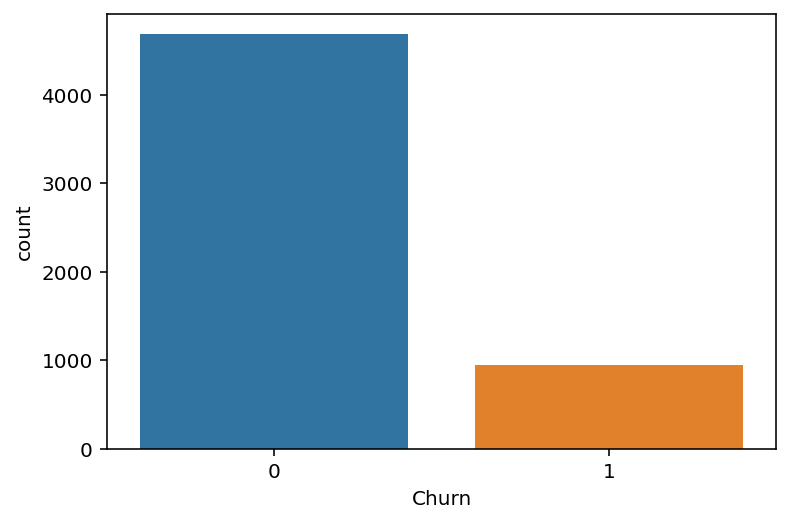

In [ ]:
sns.countplot(df[target]);

In [ ]:
#중복된 값 개수 확인
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
5625    False
5626    False
5627    False
5628    False
5629    False
Length: 5630, dtype: bool

In [ ]:
df.T.duplicated()

CustomerID                     False
Churn                          False
Tenure                         False
PreferredLoginDevice           False
CityTier                       False
WarehouseToHome                False
PreferredPaymentMode           False
Gender                         False
HourSpendOnApp                 False
NumberOfDeviceRegistered       False
PreferedOrderCat               False
SatisfactionScore              False
MaritalStatus                  False
NumberOfAddress                False
Complain                       False
OrderAmountHikeFromlastYear    False
CouponUsed                     False
OrderCount                     False
DaySinceLastOrder              False
CashbackAmount                 False
dtype: bool

**다수 클래스의 비율이 83%로 높기 때문에 정밀도, 재현율, ROC curve, AUC 등을 같이 사용할 것이다.**

In [ ]:
#고객아이디는 고유값이기 때문에 drop
df.drop(['CustomerID'], axis=1, inplace = True)

In [ ]:
df.dtypes

Churn                            int64
Tenure                         float64
PreferredLoginDevice            object
CityTier                         int64
WarehouseToHome                float64
PreferredPaymentMode            object
Gender                          object
HourSpendOnApp                 float64
NumberOfDeviceRegistered         int64
PreferedOrderCat                object
SatisfactionScore                int64
MaritalStatus                   object
NumberOfAddress                  int64
Complain                         int64
OrderAmountHikeFromlastYear    float64
CouponUsed                     float64
OrderCount                     float64
DaySinceLastOrder              float64
CashbackAmount                 float64
dtype: object

In [ ]:
#churn(이탈여부) object로 타입변경
#df['Churn'] = df['Churn'].astype('object')

In [ ]:
#결측값이 있는 특성 찾기
[(x, df[x].isnull().sum()) for x in df.columns if df[x].isnull().any()]

[('Tenure', 264),
 ('WarehouseToHome', 251),
 ('HourSpendOnApp', 255),
 ('OrderAmountHikeFromlastYear', 265),
 ('CouponUsed', 256),
 ('OrderCount', 258),
 ('DaySinceLastOrder', 307)]

In [ ]:

for i in df.columns:
    if df[i].isnull().sum() > 0:
        print(i)
        print('total null : ', df[i].isnull().sum())
        print('datatype : ', df[i].dtypes)
        print()

Tenure
total null :  264
datatype :  float64

WarehouseToHome
total null :  251
datatype :  float64

HourSpendOnApp
total null :  255
datatype :  float64

OrderAmountHikeFromlastYear
total null :  265
datatype :  float64

CouponUsed
total null :  256
datatype :  float64

OrderCount
total null :  258
datatype :  float64

DaySinceLastOrder
total null :  307
datatype :  float64



In [ ]:
#결측값이 있는 특징들의 평균값, 중앙값, 최빈값
for i in df.columns:
  if df[i].isnull().sum() >0:
   print(i)
   print('결측치 개수 : ', df[i].isnull().sum())
   print('데이터 타입 : ', df[i].dtypes)
   print('평균 : ',df[i].mean())
   print('중앙값 : ',df[i].median())
   print('최빈값 : ',df[i].mode())
   print()

Tenure
결측치 개수 :  264
데이터 타입 :  float64
평균 :  10.189899366380917
중앙값 :  9.0
최빈값 :  0    1.0
dtype: float64

WarehouseToHome
결측치 개수 :  251
데이터 타입 :  float64
평균 :  15.639895891429633
중앙값 :  14.0
최빈값 :  0    9.0
dtype: float64

HourSpendOnApp
결측치 개수 :  255
데이터 타입 :  float64
평균 :  2.9315348837209303
중앙값 :  3.0
최빈값 :  0    3.0
dtype: float64

OrderAmountHikeFromlastYear
결측치 개수 :  265
데이터 타입 :  float64
평균 :  15.707921714818266
중앙값 :  15.0
최빈값 :  0    14.0
dtype: float64

CouponUsed
결측치 개수 :  256
데이터 타입 :  float64
평균 :  1.7510234462225531
중앙값 :  1.0
최빈값 :  0    1.0
dtype: float64

OrderCount
결측치 개수 :  258
데이터 타입 :  float64
평균 :  3.0080044676098288
중앙값 :  2.0
최빈값 :  0    2.0
dtype: float64

DaySinceLastOrder
결측치 개수 :  307
데이터 타입 :  float64
평균 :  4.543490512868683
중앙값 :  3.0
최빈값 :  0    3.0
dtype: float64



Text(0, 0.5, 'Values')

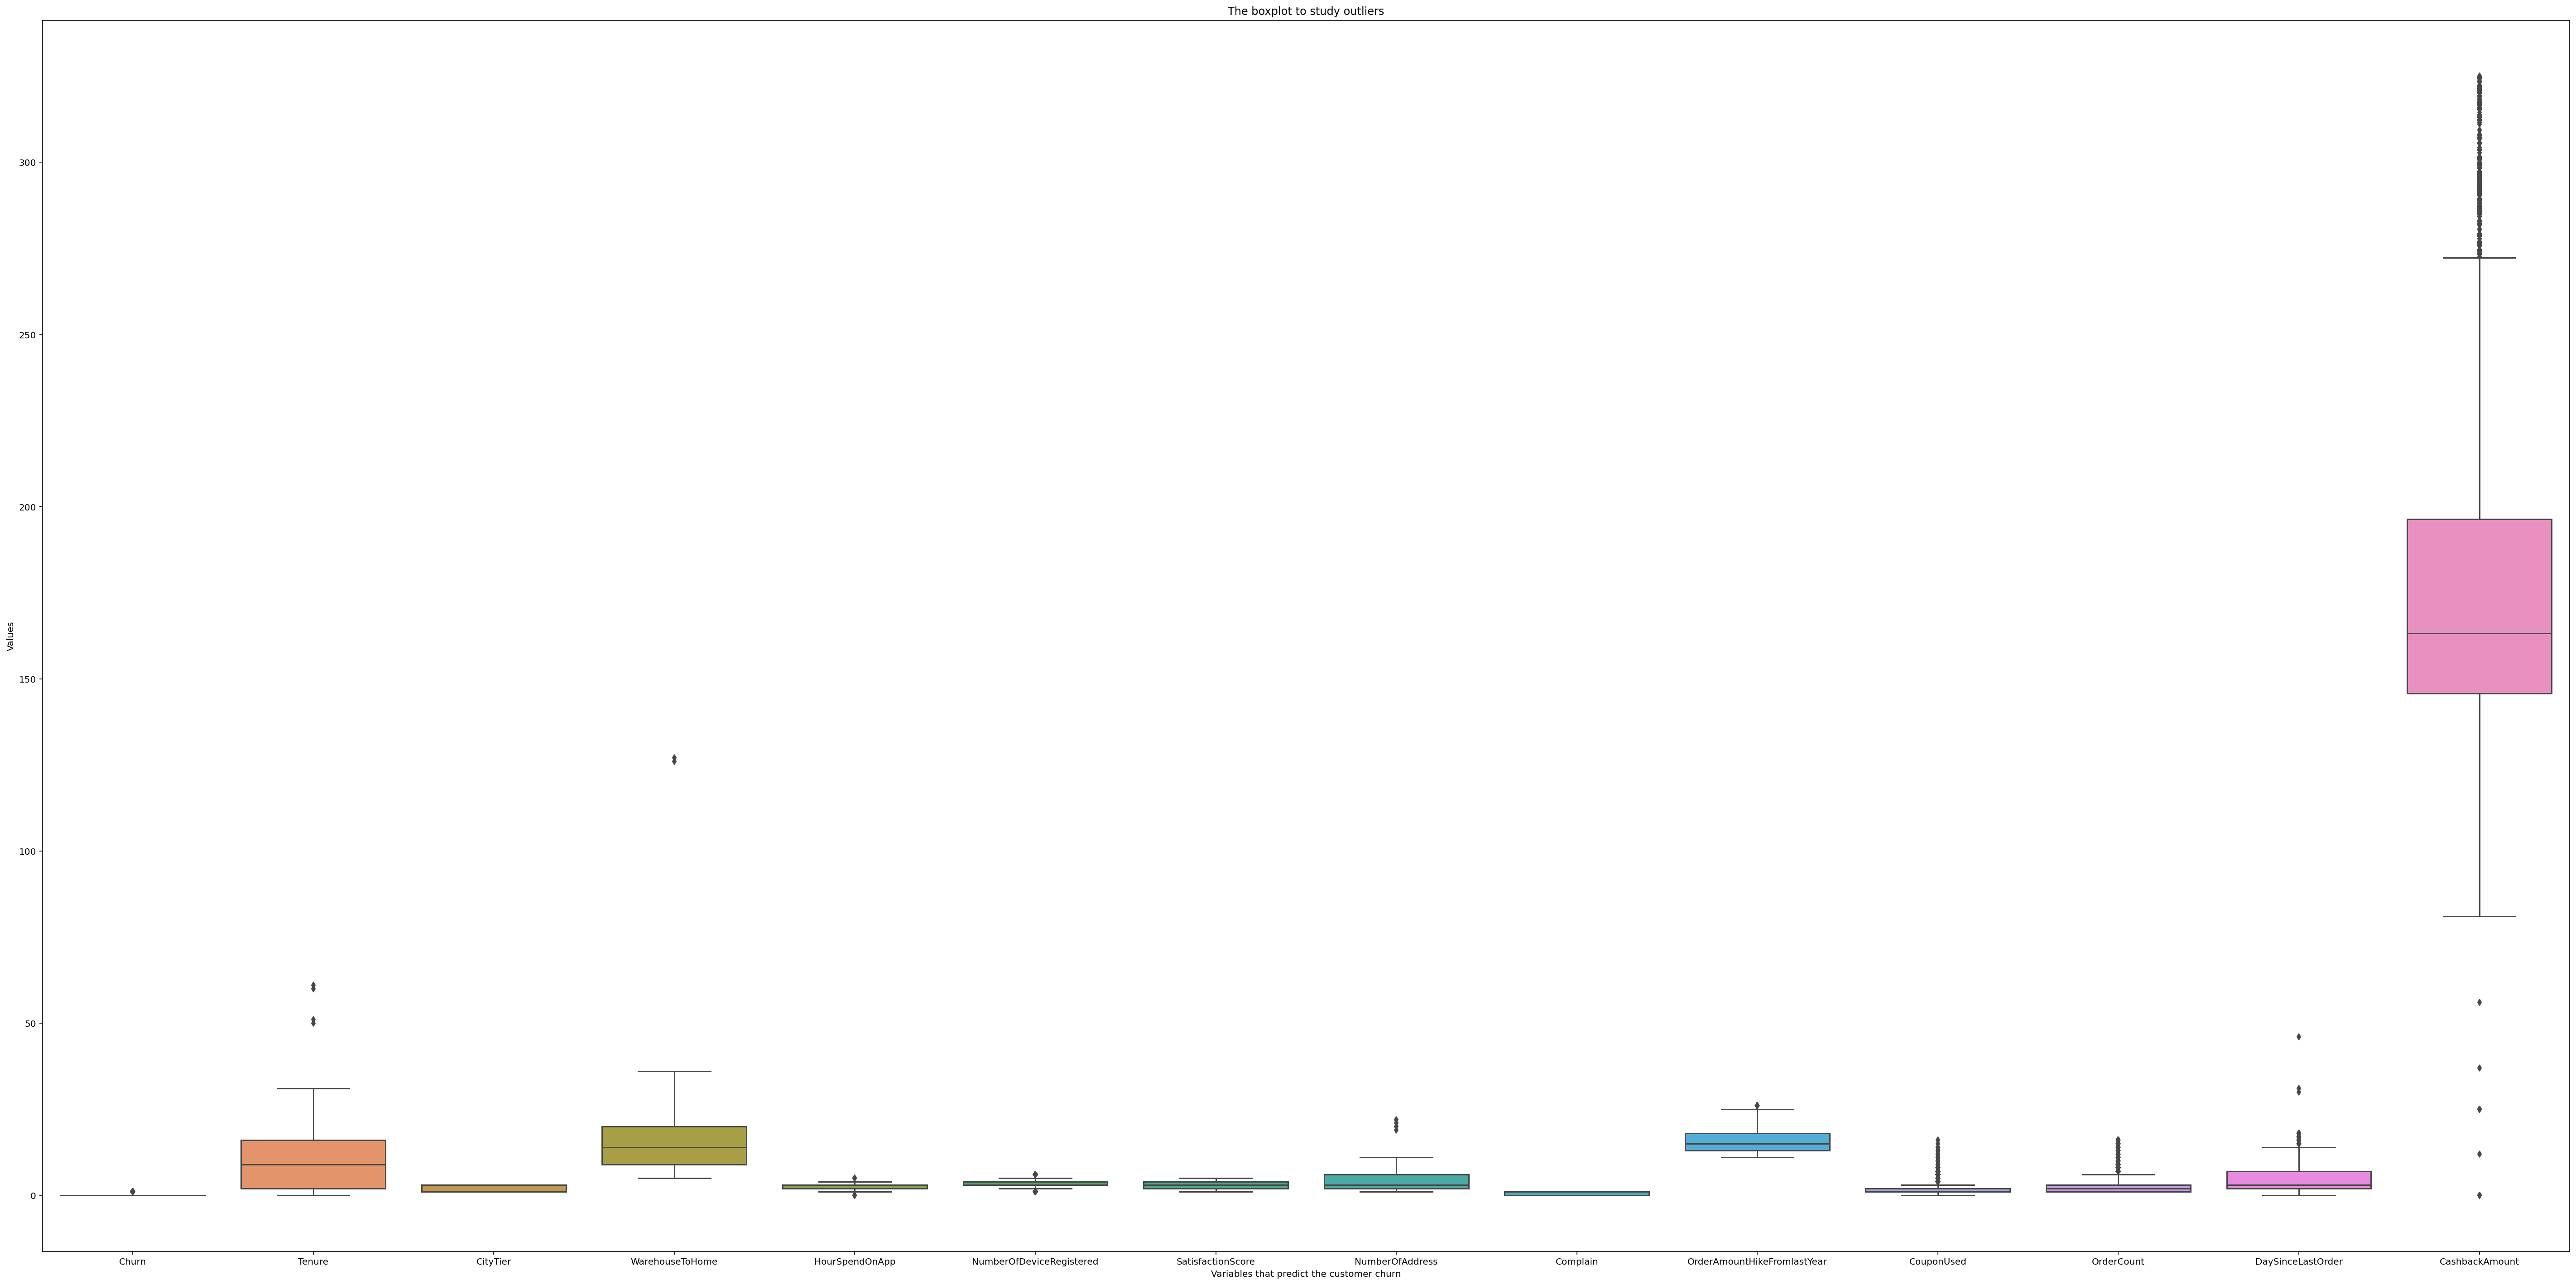

In [ ]:
#outlier 이상치 확인
plt.figure(figsize=(50,25))
sns.boxplot(data=df)
plt.title('The boxplot to study outliers')
plt.xlabel('Variables that predict the customer churn')
plt.ylabel('Values')

In [ ]:
#결측치 중앙값으로 채우기 (이상치가 많이 발견되어서 평균값보다는 중앙값이 더 좋다고 판단)
for i in df.columns:
    if df[i].isnull().sum() > 0:
        df[i].fillna(df[i].median(),inplace=True)

**새로운 특성 만들기**

In [ ]:
df['avg_cashback']=df['CashbackAmount']/df['OrderCount']

In [ ]:
df.isna().sum().sort_values()

Churn                          0
DaySinceLastOrder              0
OrderCount                     0
CouponUsed                     0
OrderAmountHikeFromlastYear    0
Complain                       0
NumberOfAddress                0
MaritalStatus                  0
SatisfactionScore              0
PreferedOrderCat               0
NumberOfDeviceRegistered       0
HourSpendOnApp                 0
Gender                         0
PreferredPaymentMode           0
WarehouseToHome                0
CityTier                       0
PreferredLoginDevice           0
Tenure                         0
CashbackAmount                 0
avg_cashback                   0
dtype: int64

In [ ]:
num=[]
for i in df.columns:
  if df[i].dtype!='object':
    num.append(i)

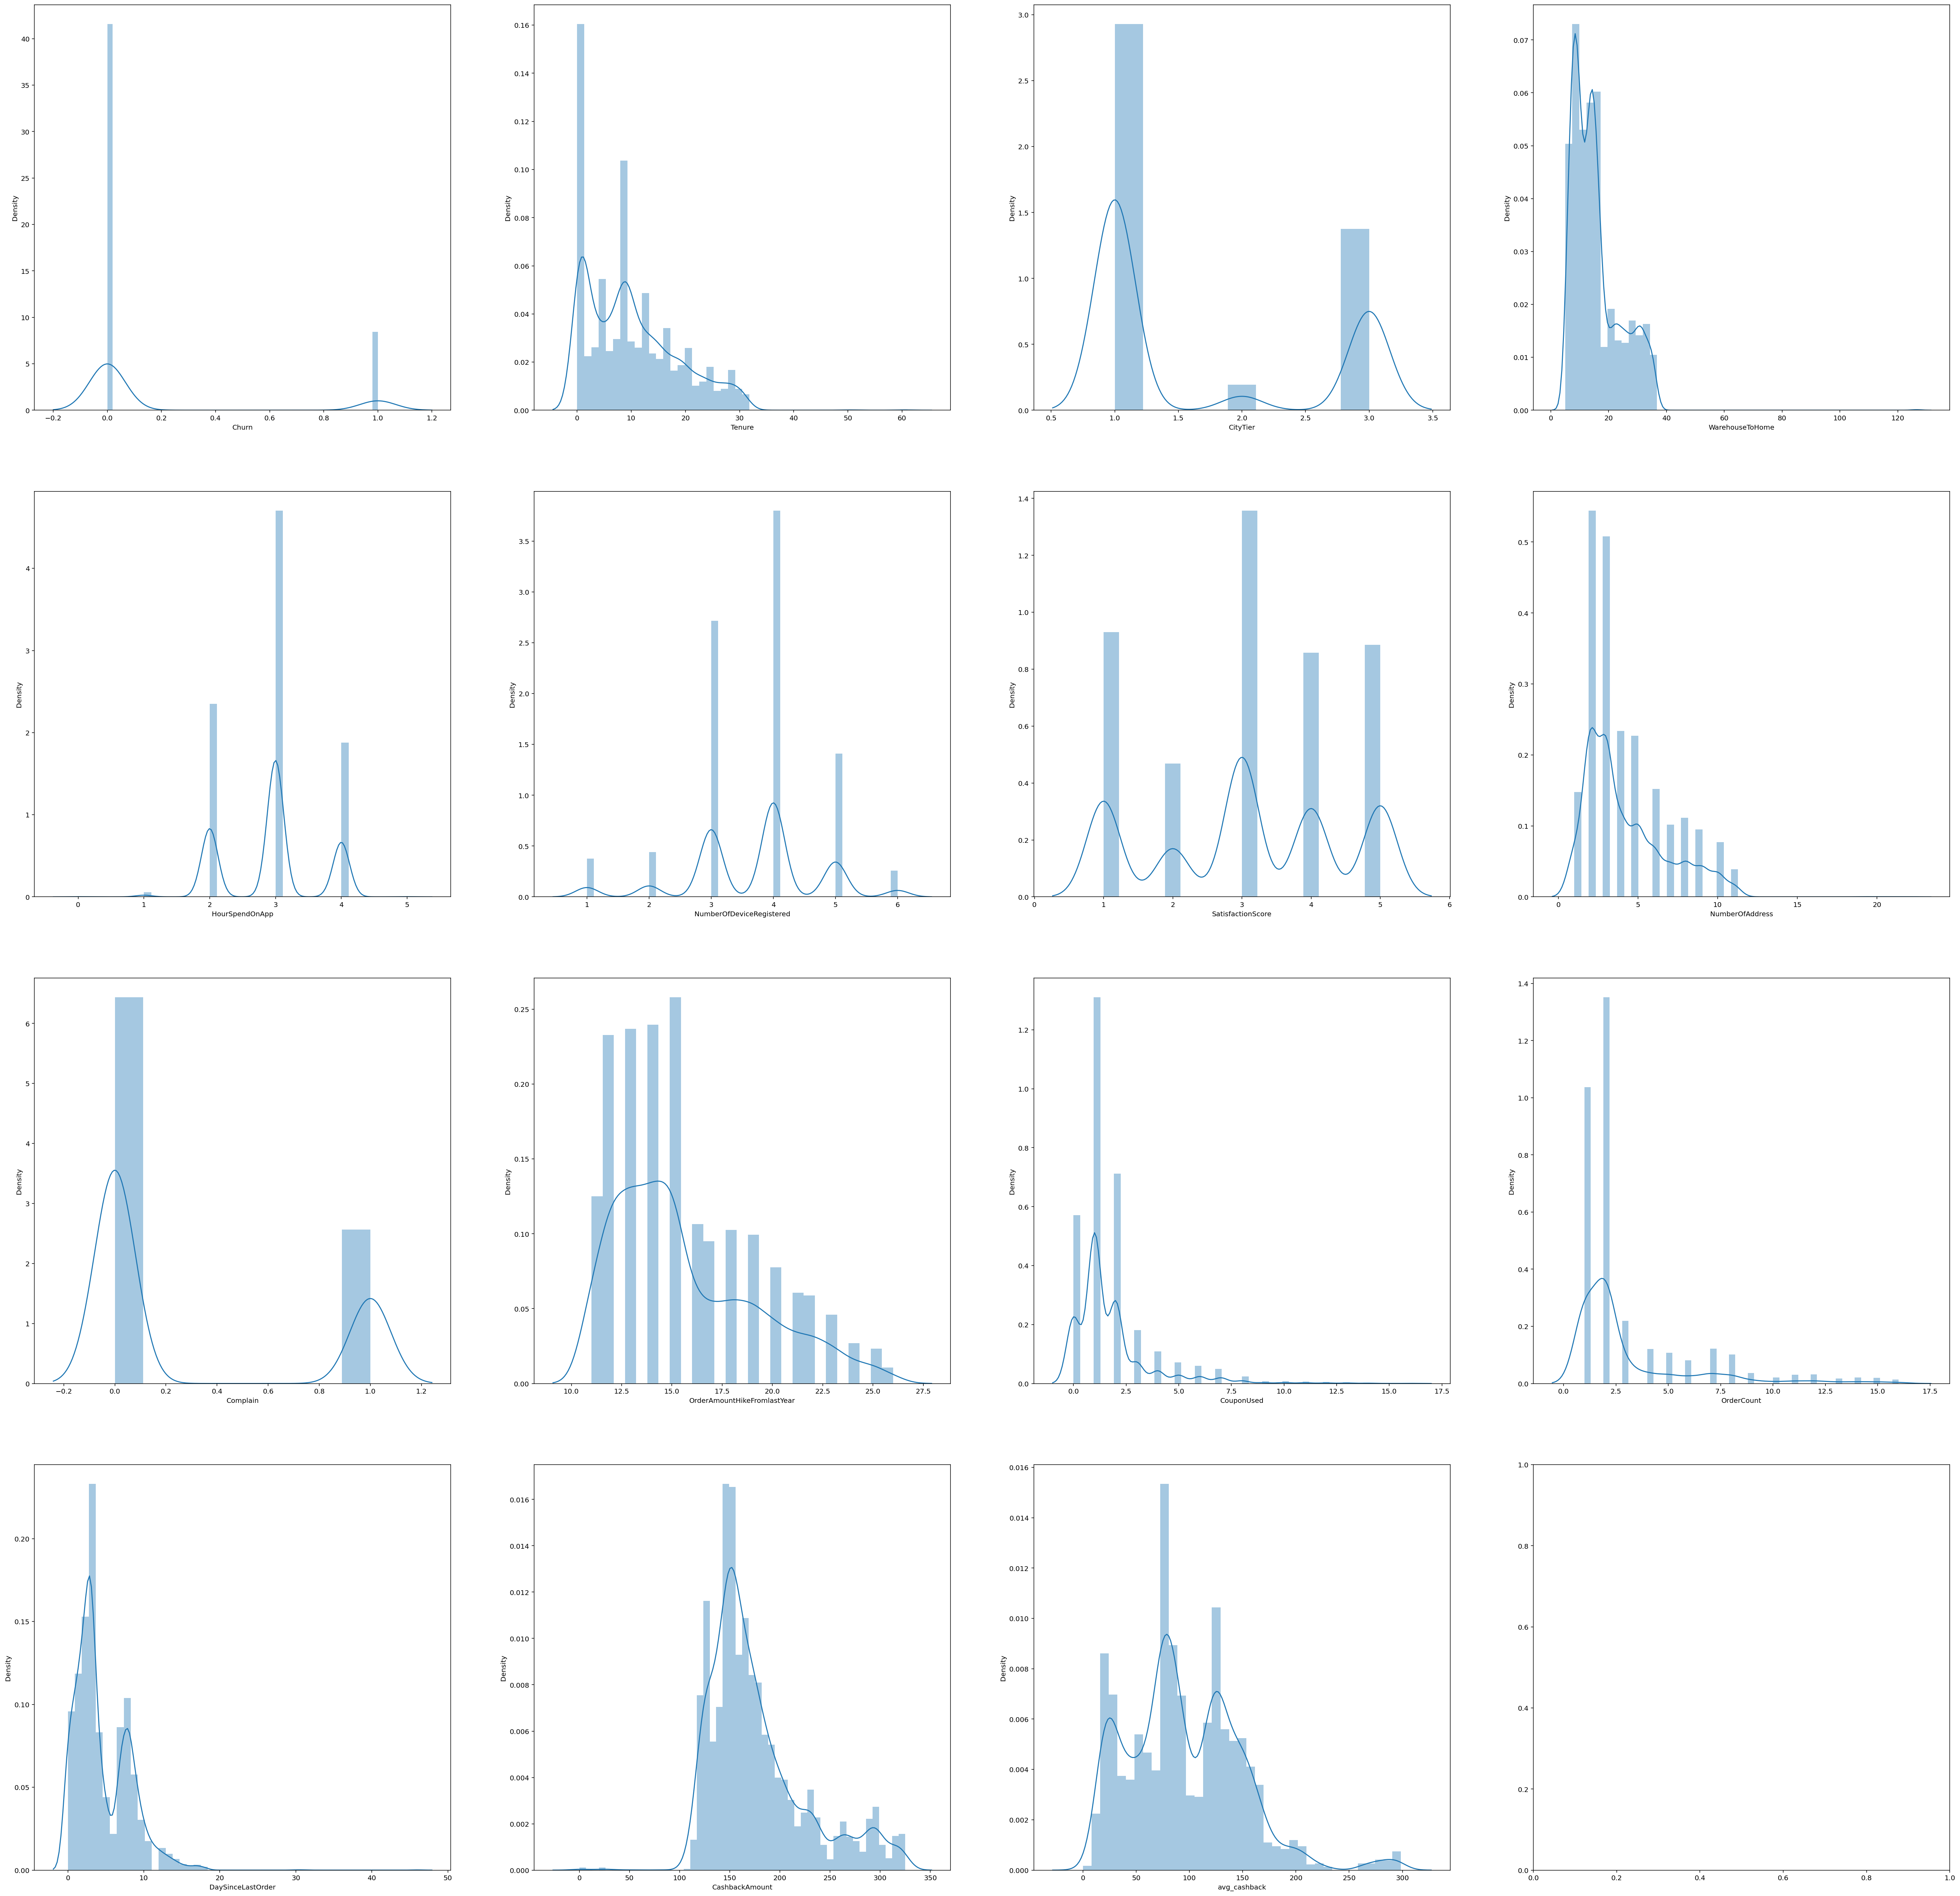

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(50, 50))
for i, subplot in zip(num, ax.flatten()):
    sns.distplot(df[i], ax=subplot)

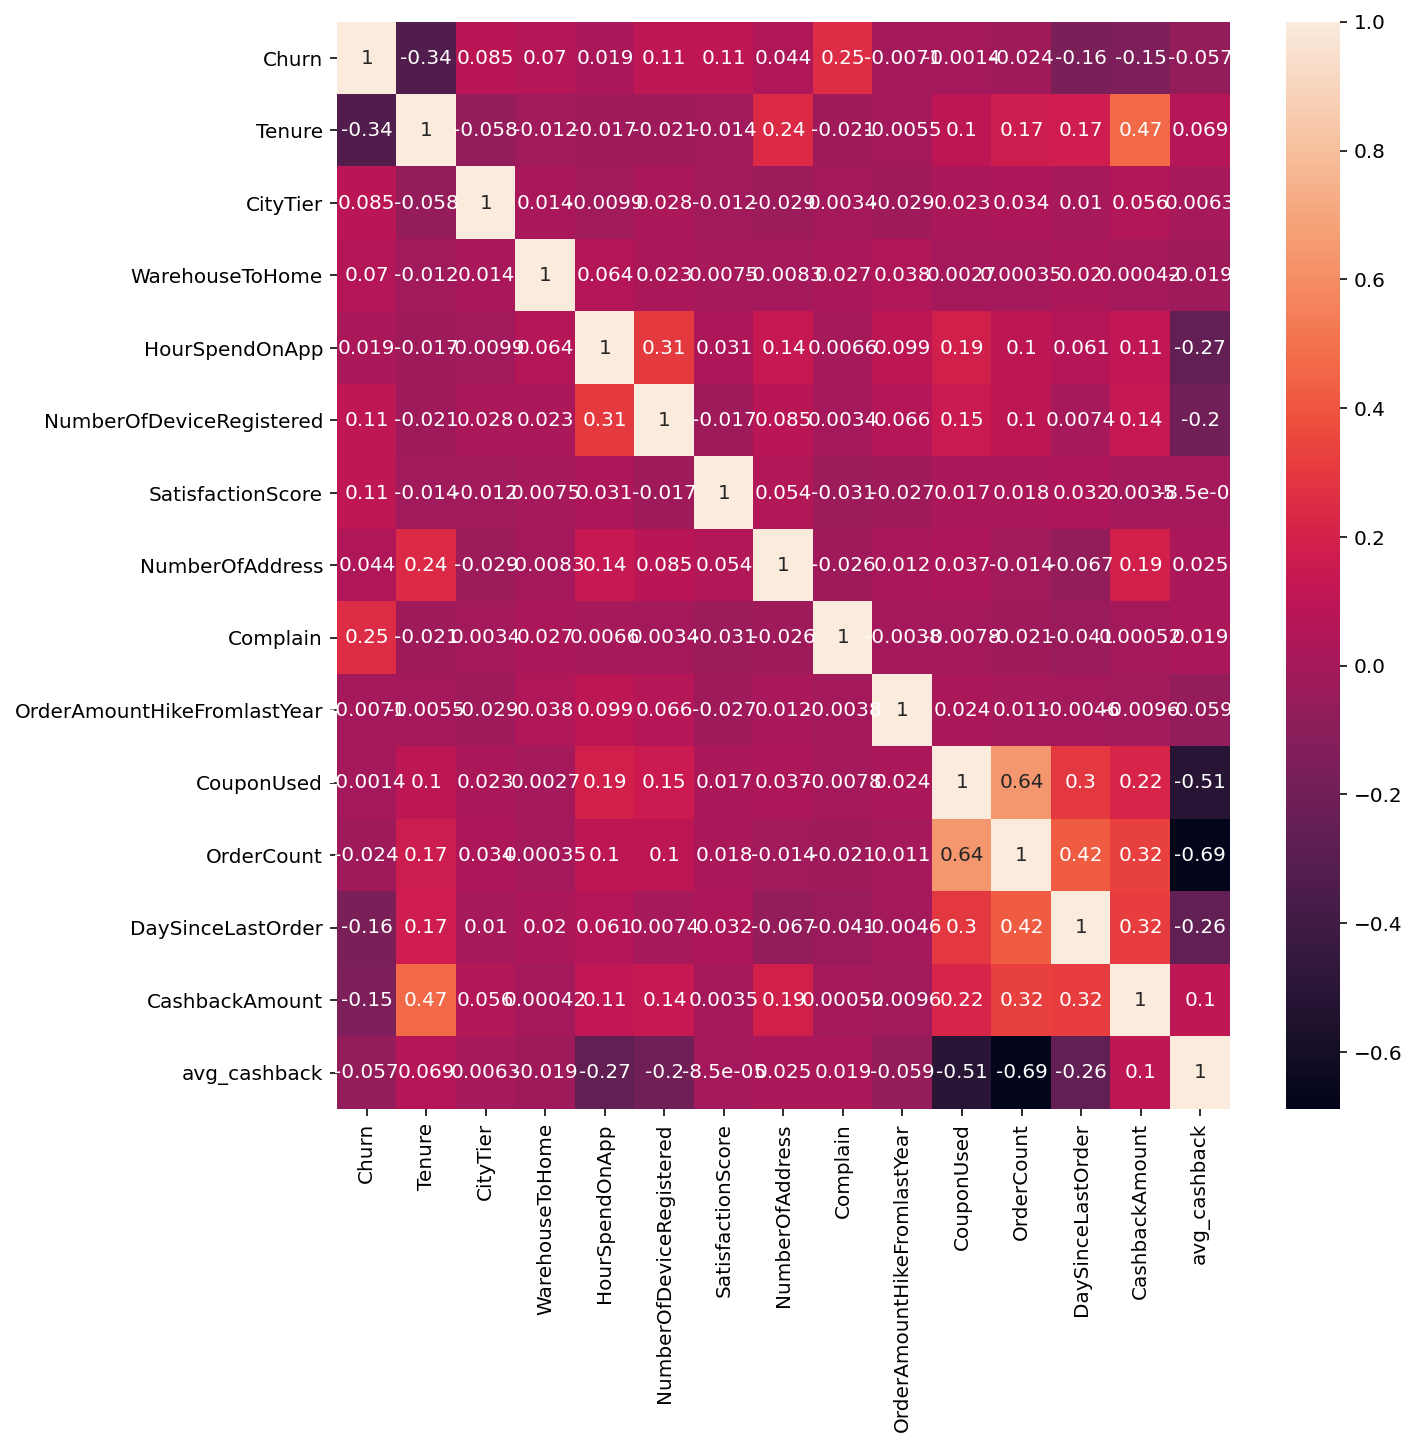

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True)

### **baseline model(기준모델)**  
분류문제 : 타겟의 최빈 클래스

#### **데이터 나누기**

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(df, test_size=0.2, random_state=2)
train.shape, val.shape

((4504, 20), (1126, 20))

In [ ]:
target = 'Churn'
features = df.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

### **baseline**  
누수 없음

In [ ]:
pipe = make_pipeline(
    OneHotEncoder(),  
    StandardScaler(),
    DecisionTreeClassifier(max_depth=5, random_state=2)
)

pipe.fit(X_train, y_train)
print('훈련 정확도', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))
y_pred = pipe.predict(X_val)
print('F1-score: ', f1_score(y_val, y_pred))

훈련 정확도 0.9056394316163411
검증 정확도:  0.88898756660746
F1-score:  0.6056782334384858


In [ ]:
%%time
#onehot_randomforest
pipe_r = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
)

pipe_r.fit(X_train, y_train)
print('훈련 정확도', pipe_r.score(X_train, y_train))
print('검증 정확도', pipe_r.score(X_val, y_val))

y_pred = pipe_r.predict(X_val)
print('F1-score: ', f1_score(y_val, y_pred))

훈련 정확도 1.0
검증 정확도 0.9733570159857904
F1-score:  0.9132947976878613
CPU times: user 1.35 s, sys: 53 ms, total: 1.4 s
Wall time: 1.16 s


In [ ]:
%%time
#ordinal_randomforest
pipe_ord = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=10, n_jobs=-1, oob_score=True)
)

pipe_ord.fit(X_train, y_train)
print('훈련 정확도', pipe_ord.score(X_train, y_train))
print('검증 정확도', pipe_ord.score(X_val, y_val))

y_pred = pipe_ord.predict(X_val)
print('F1-score: ', f1_score(y_val, y_pred))

훈련 정확도 1.0
검증 정확도 0.9822380106571936
F1-score:  0.9438202247191011
CPU times: user 1.26 s, sys: 45.3 ms, total: 1.31 s
Wall time: 1.02 s


**randomforest model** 최적 하이퍼파라미터

In [ ]:
param_distributions = { 
    'simpleimputer__strategy':['mean','median','most_frequent'],
    "randomforestclassifier__n_estimators": [10,100,200,300],
    "randomforestclassifier__max_depth": [5,10,15],
    "randomforestclassifier__max_features": list(range(3,12,3)),
}

model_r = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier()
)

search = RandomizedSearchCV(
    model_r, 
    param_distributions=param_distributions, 
    n_iter=50, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=2,
)

search.fit(X_train, y_train);
model_r = search.best_estimator_
y_val_pred = model_r.predict(X_val)
print('\n최적 하이퍼파라미터: ', search.best_params_)
print('훈련 정확도', model_r.score(X_train, y_train))
print('검증 정확도', model_r.score(X_val, y_val))

y_pred = model_r.predict(X_val)
print('F1-score: ', f1_score(y_val, y_pred))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1


최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__max_features': 6, 'randomforestclassifier__max_depth': 15}
훈련 정확도 1.0
검증 정확도 0.9804618117229129
F1-score:  0.9382022471910112


In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
# Ordinal encoding

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터

model = XGBClassifier(
    random_state = 42,
    n_estimators = 100,  
    max_depth = 7,        
    learning_rate = 0.2,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='error', # #(wrong cases)/#(all cases)
          )


[0]	validation_0-error:0.075488	validation_1-error:0.101243
[1]	validation_0-error:0.071714	validation_1-error:0.099467
[2]	validation_0-error:0.057948	validation_1-error:0.080817
[3]	validation_0-error:0.05484	validation_1-error:0.083481
[4]	validation_0-error:0.048623	validation_1-error:0.073712
[5]	validation_0-error:0.045959	validation_1-error:0.07016
[6]	validation_0-error:0.044183	validation_1-error:0.07016
[7]	validation_0-error:0.042185	validation_1-error:0.068384
[8]	validation_0-error:0.038854	validation_1-error:0.067496
[9]	validation_0-error:0.037522	validation_1-error:0.060391
[10]	validation_0-error:0.037078	validation_1-error:0.057726
[11]	validation_0-error:0.034636	validation_1-error:0.053286
[12]	validation_0-error:0.031972	validation_1-error:0.05151
[13]	validation_0-error:0.032638	validation_1-error:0.052398
[14]	validation_0-error:0.030861	validation_1-error:0.052398
[15]	validation_0-error:0.029307	validation_1-error:0.052398
[16]	validation_0-error:0.028419	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
from sklearn.metrics import classification_report
print( model.score(X_val_encoded, y_val))

print(classification_report(y_val, model.predict(X_val_encoded)))

0.9804618117229129
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       943
           1       0.94      0.94      0.94       183

    accuracy                           0.98      1126
   macro avg       0.96      0.96      0.96      1126
weighted avg       0.98      0.98      0.98      1126



Text(0.5, 1.0, 'Confusion matrix, n = 1126')

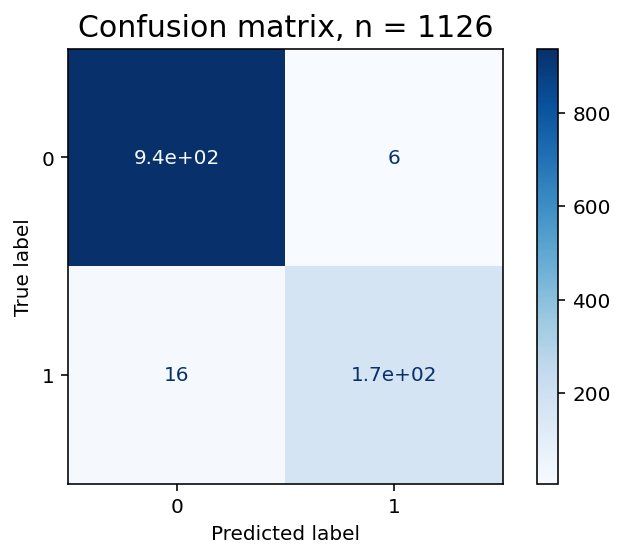

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(model_r, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)

In [ ]:
from sklearn.metrics import classification_report
y_pred = model_r.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       943
           1       0.97      0.91      0.94       183

    accuracy                           0.98      1126
   macro avg       0.97      0.95      0.96      1126
weighted avg       0.98      0.98      0.98      1126



In [ ]:
from sklearn.metrics import classification_report
y_pred = pipe_r.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       943
           1       0.97      0.86      0.91       183

    accuracy                           0.97      1126
   macro avg       0.97      0.93      0.95      1126
weighted avg       0.97      0.97      0.97      1126



In [ ]:
from sklearn.metrics import roc_auc_score

y_pred_proba = model_r.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))

AUC score:  0.9912962351291368


Text(0, 0.5, 'TPR')

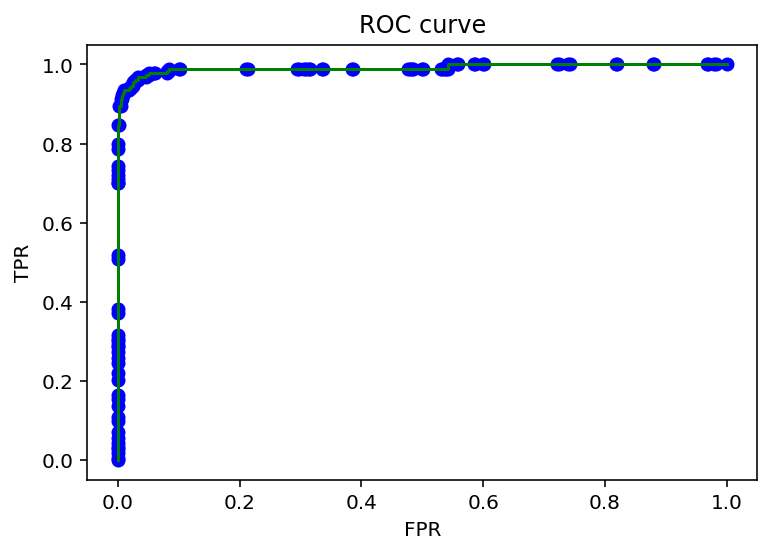

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

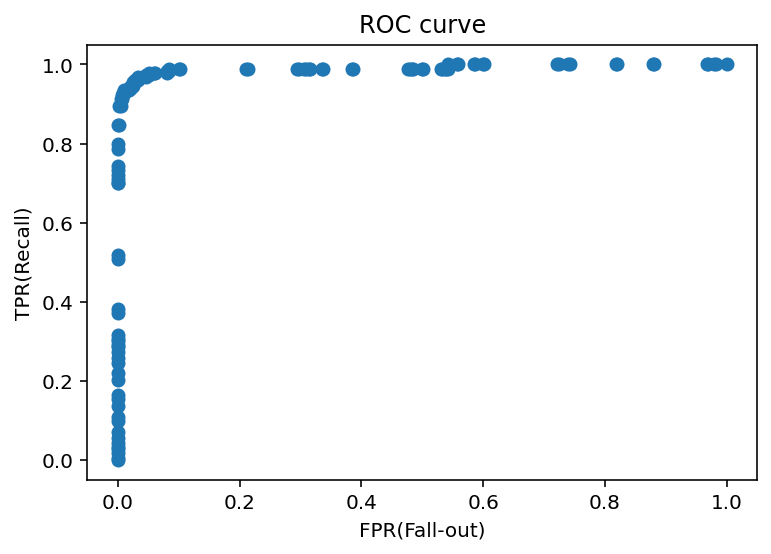

In [ ]:
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [ ]:
from scipy.stats import randint, uniform
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

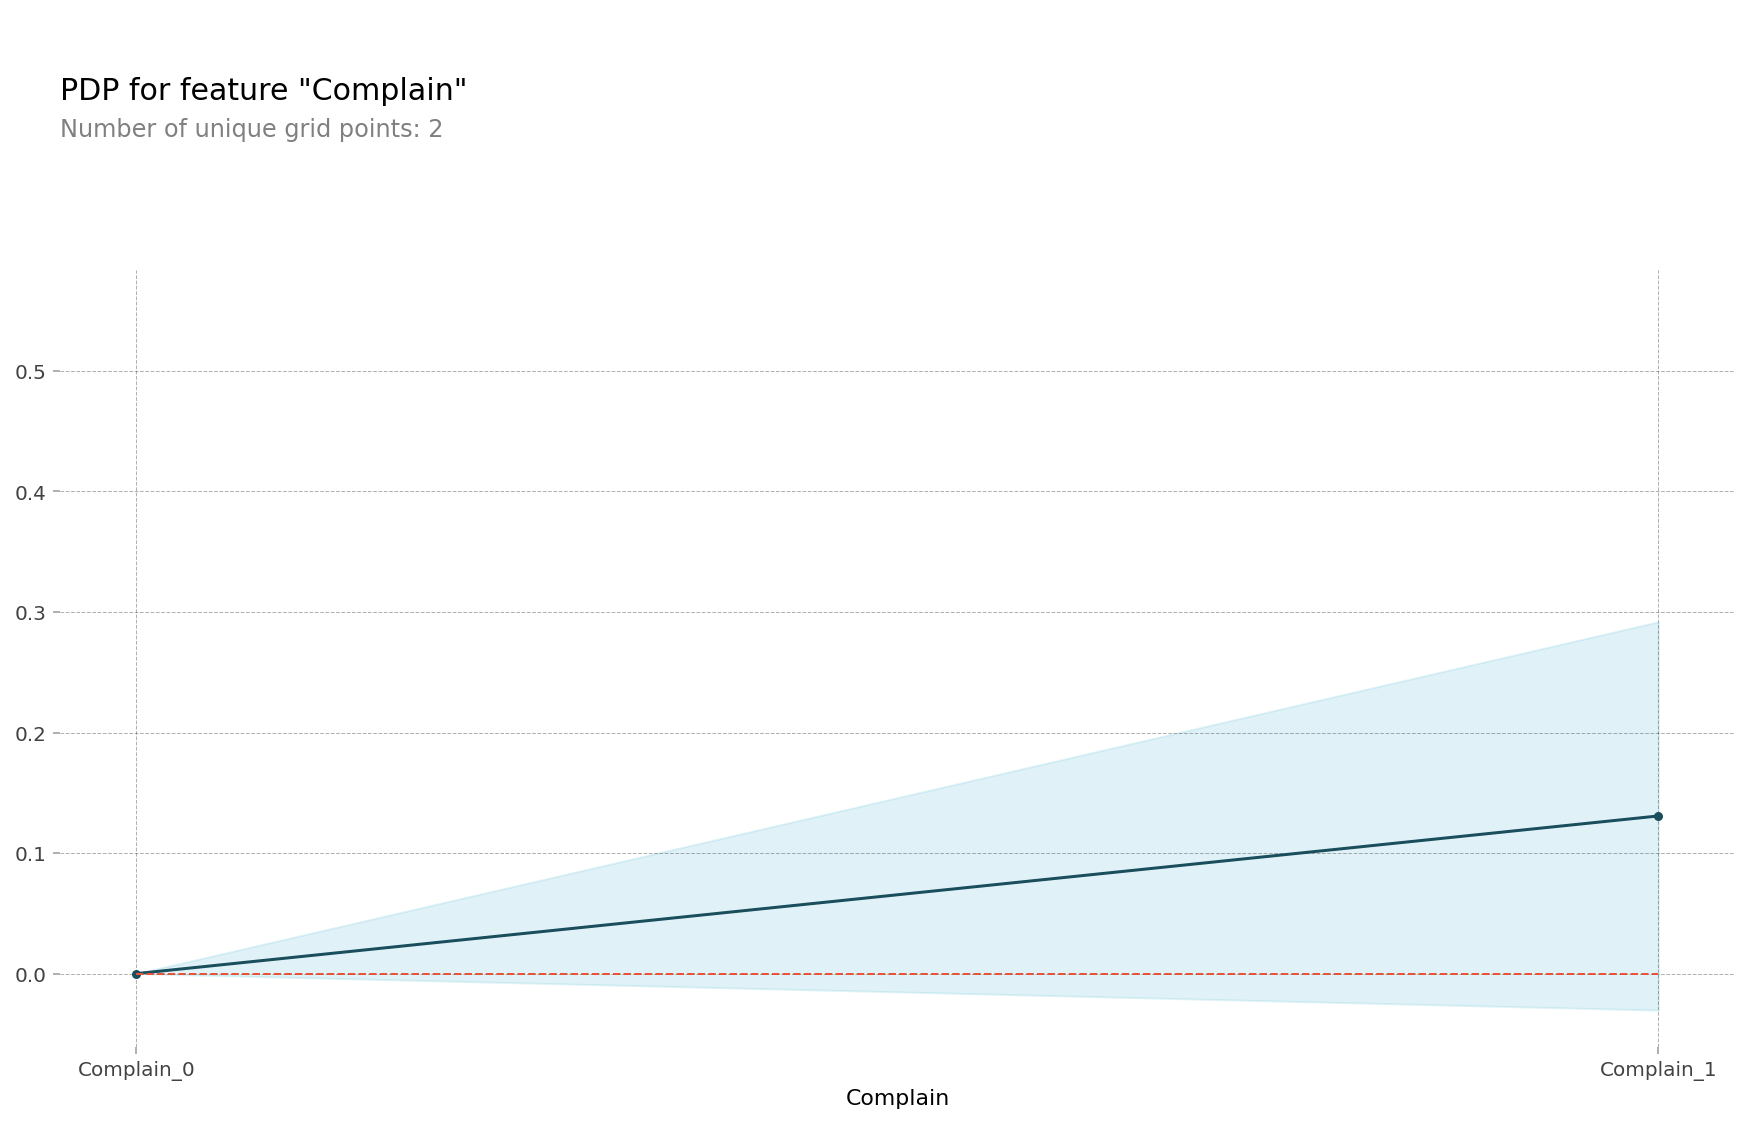

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Complain'
isolated = pdp_isolate(
    model=pipe_ord, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=20 # default=10
)
pdp_plot(isolated, feature_name=feature);


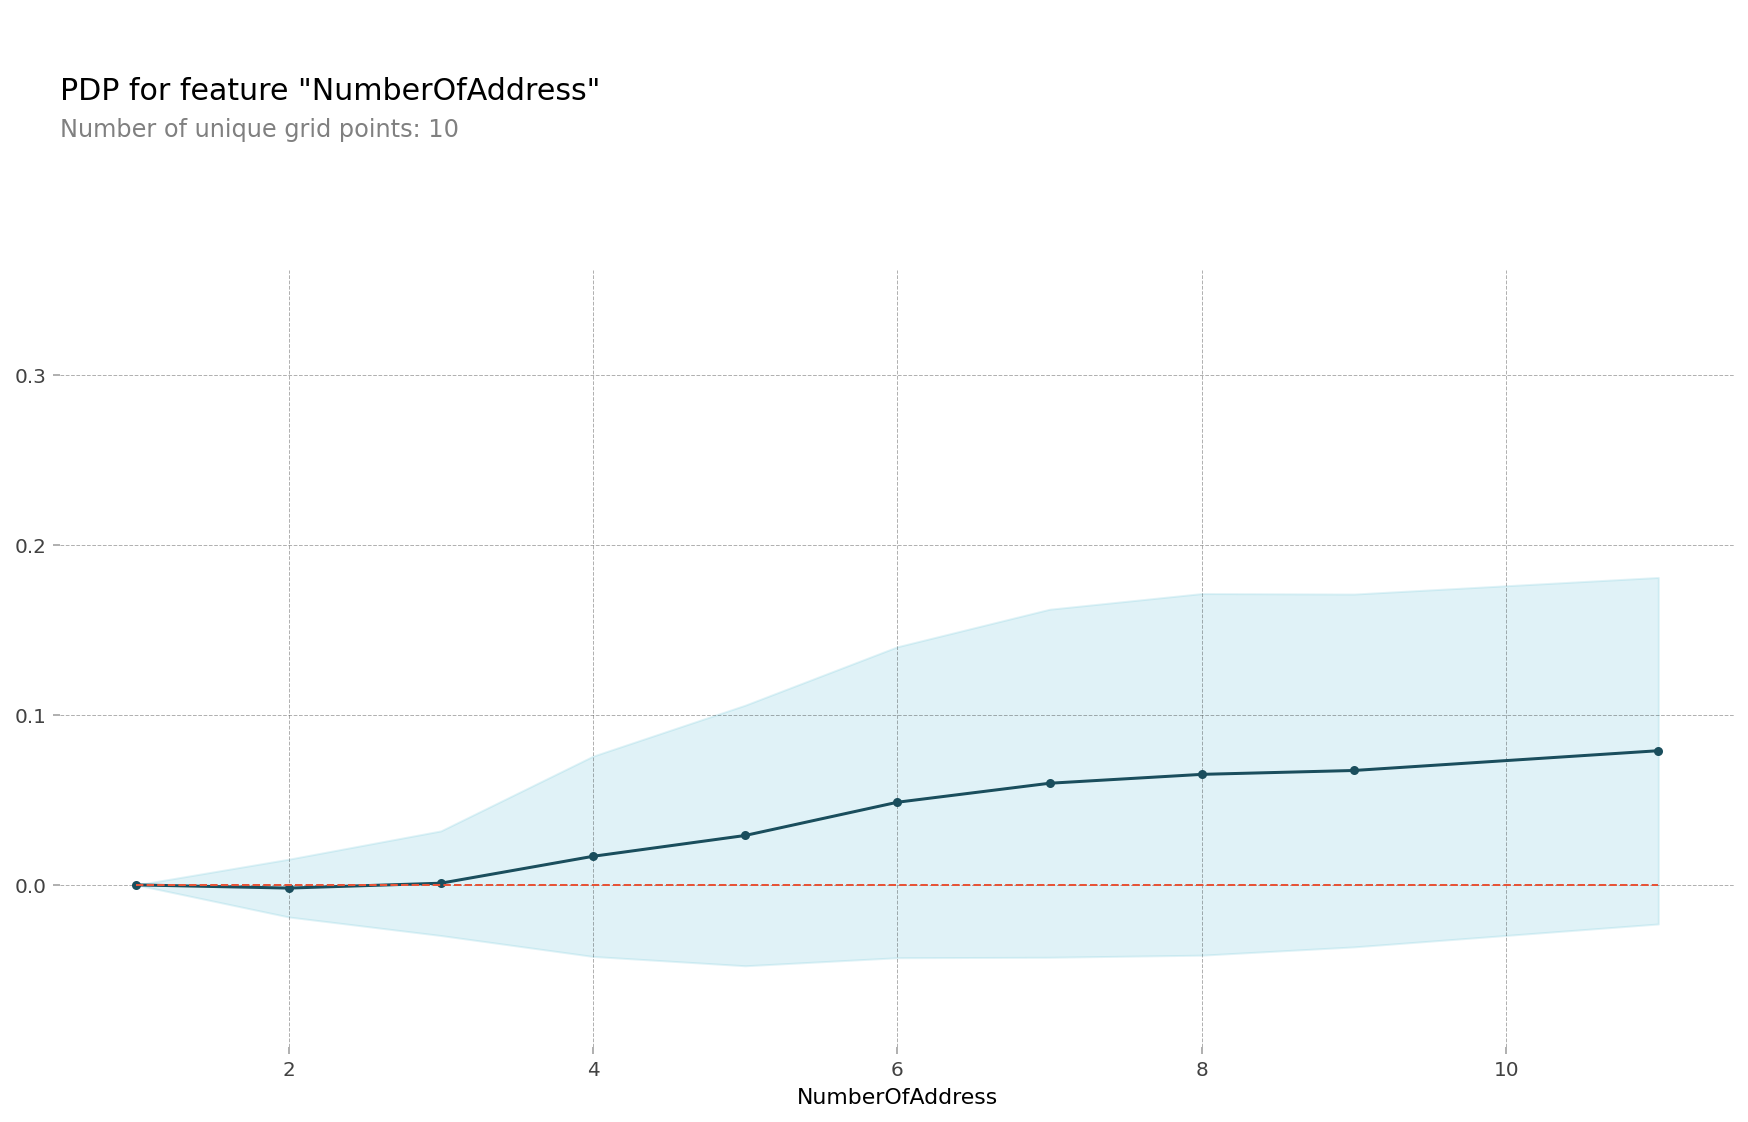

In [ ]:
feature = 'NumberOfAddress'
isolated = pdp_isolate(
    model=pipe_ord, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=20 # default=10
)
pdp_plot(isolated, feature_name=feature);


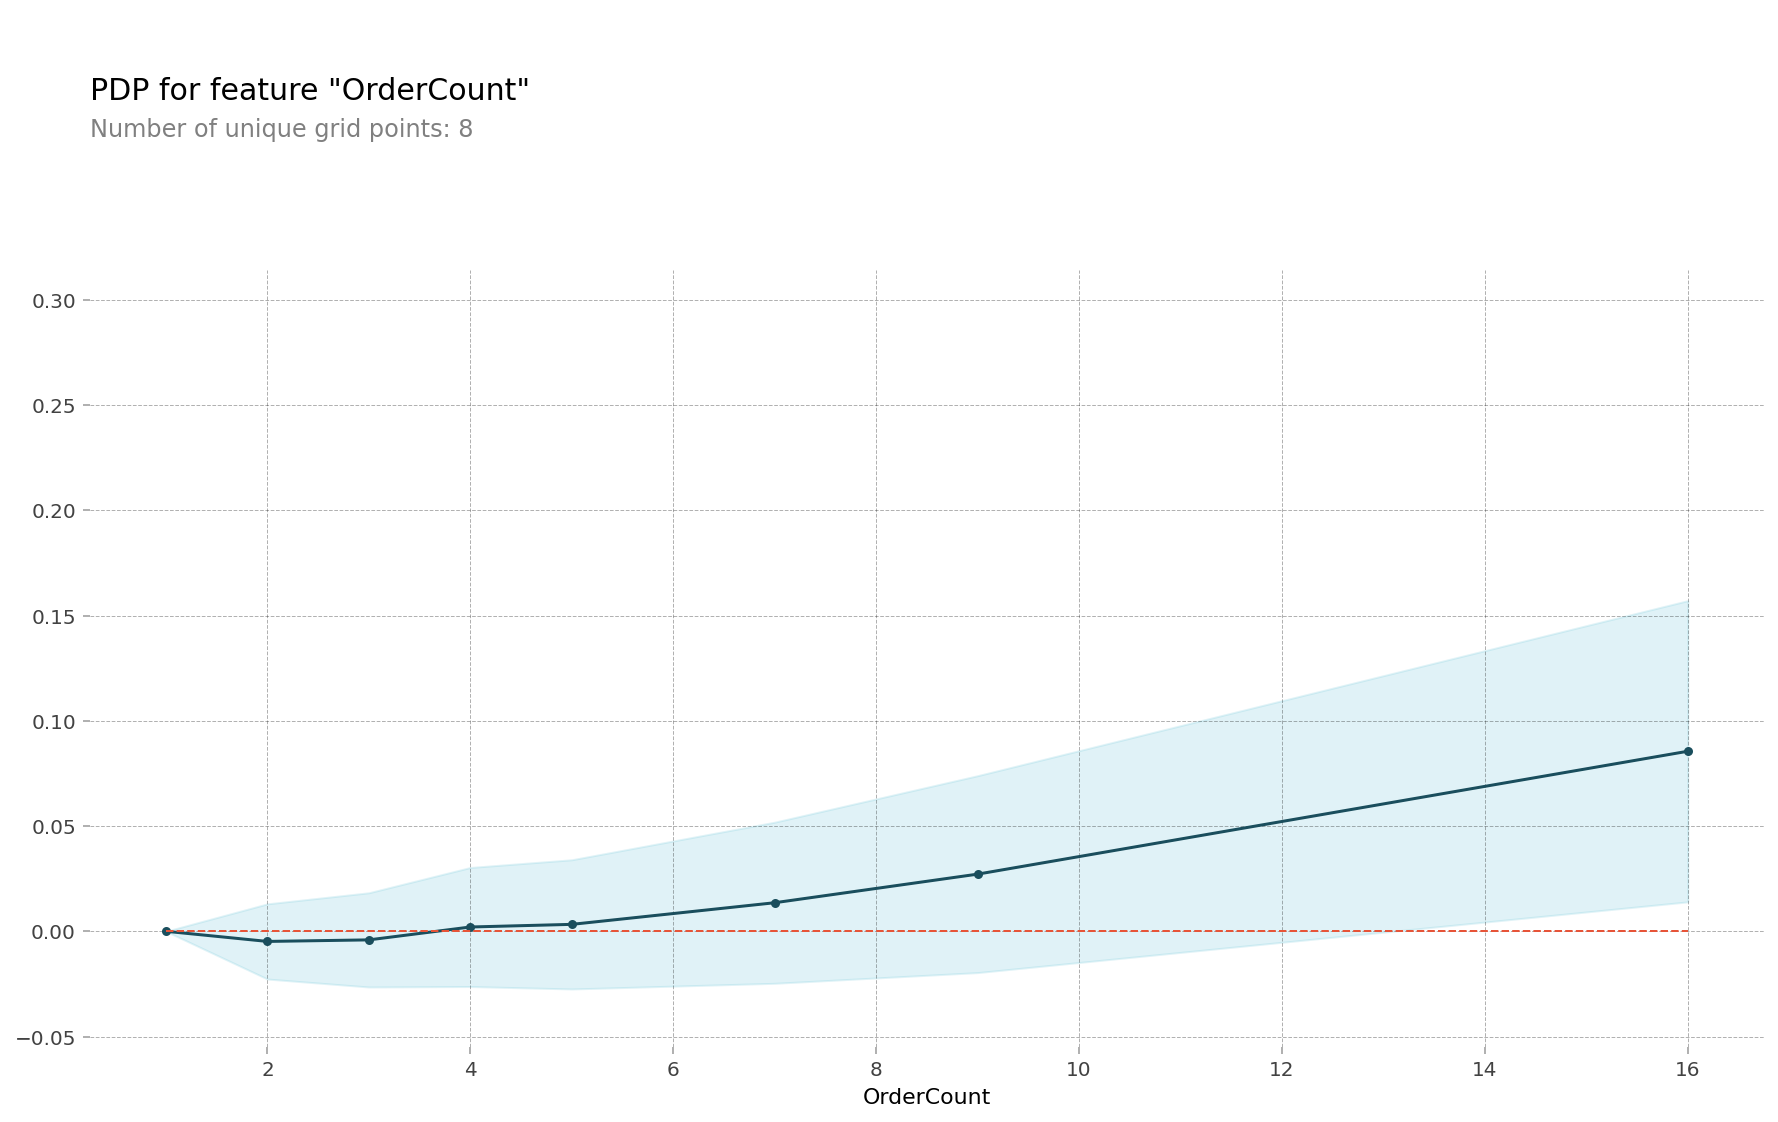

In [ ]:
feature = 'OrderCount'
isolated = pdp_isolate(
    model=pipe_ord, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=20 # default=10
)
pdp_plot(isolated, feature_name=feature);


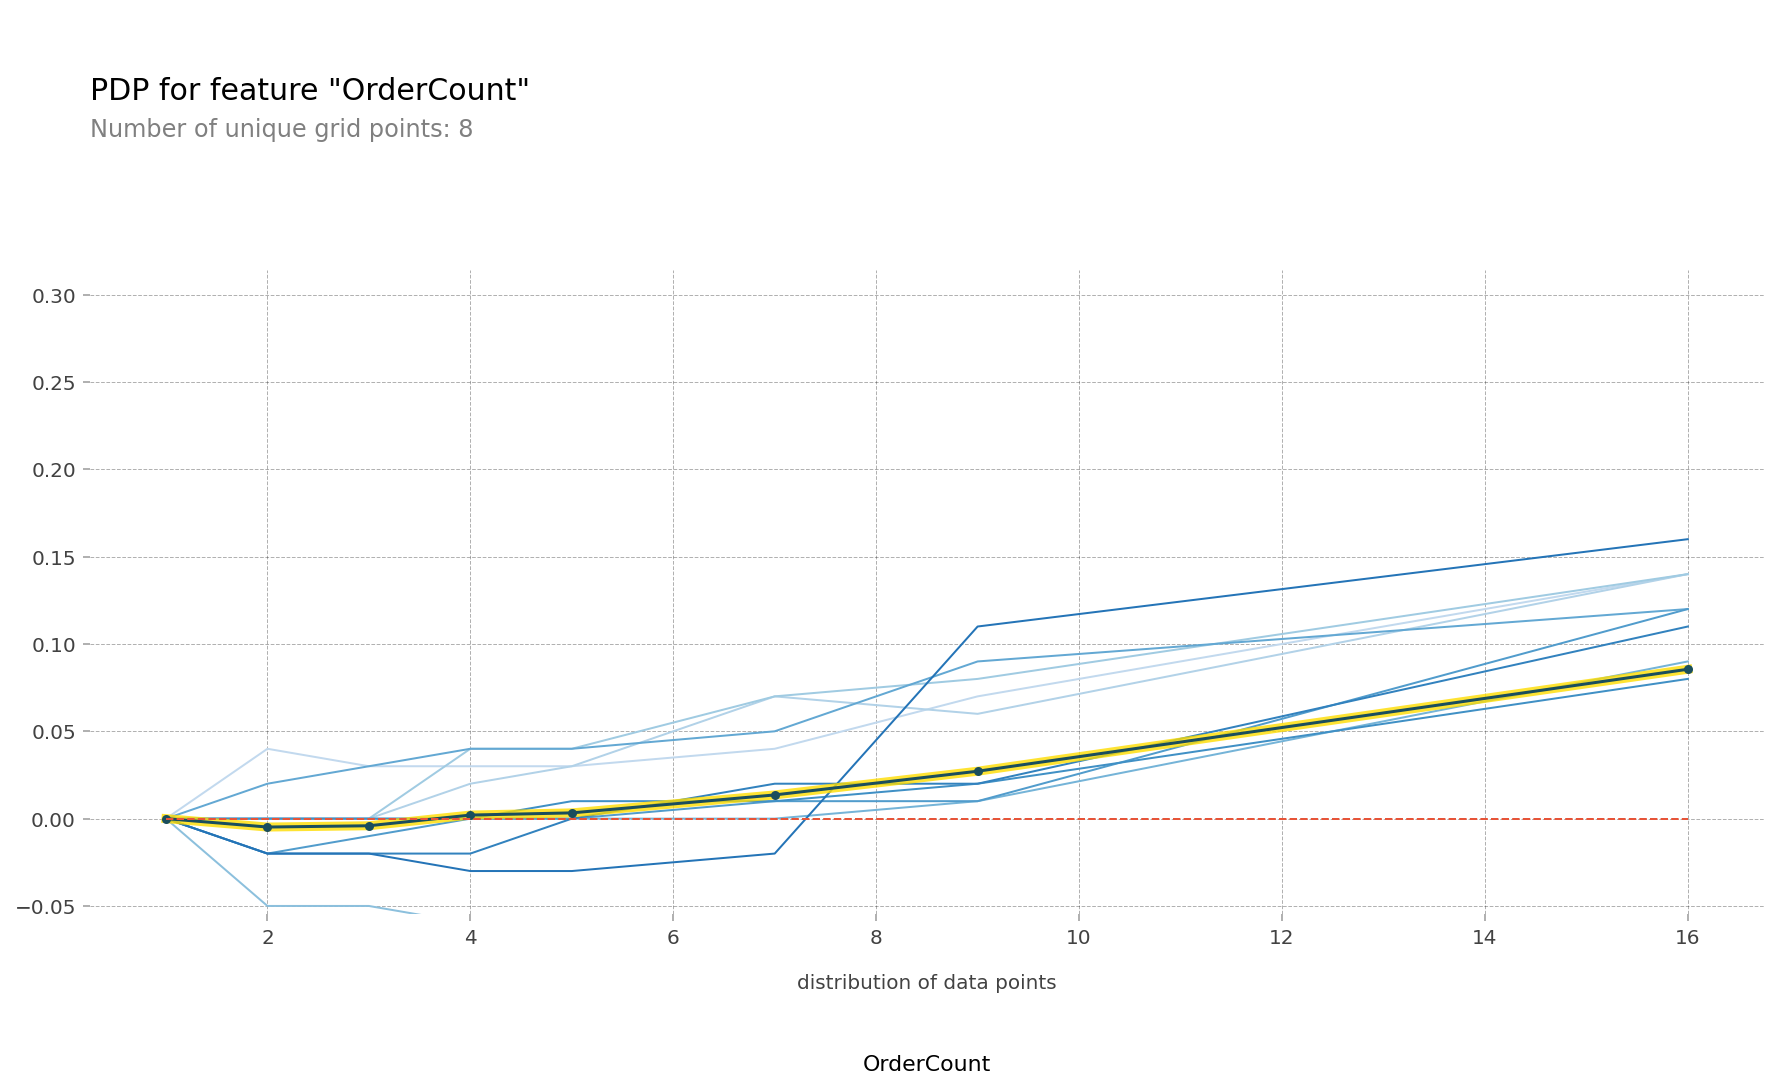

In [ ]:
pdp_plot(isolated
         , feature_name=feature
         , plot_lines=True # ICE plots
         , frac_to_plot=10
         , plot_pts_dist=True) 

plt.xlim(20000,150000);

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

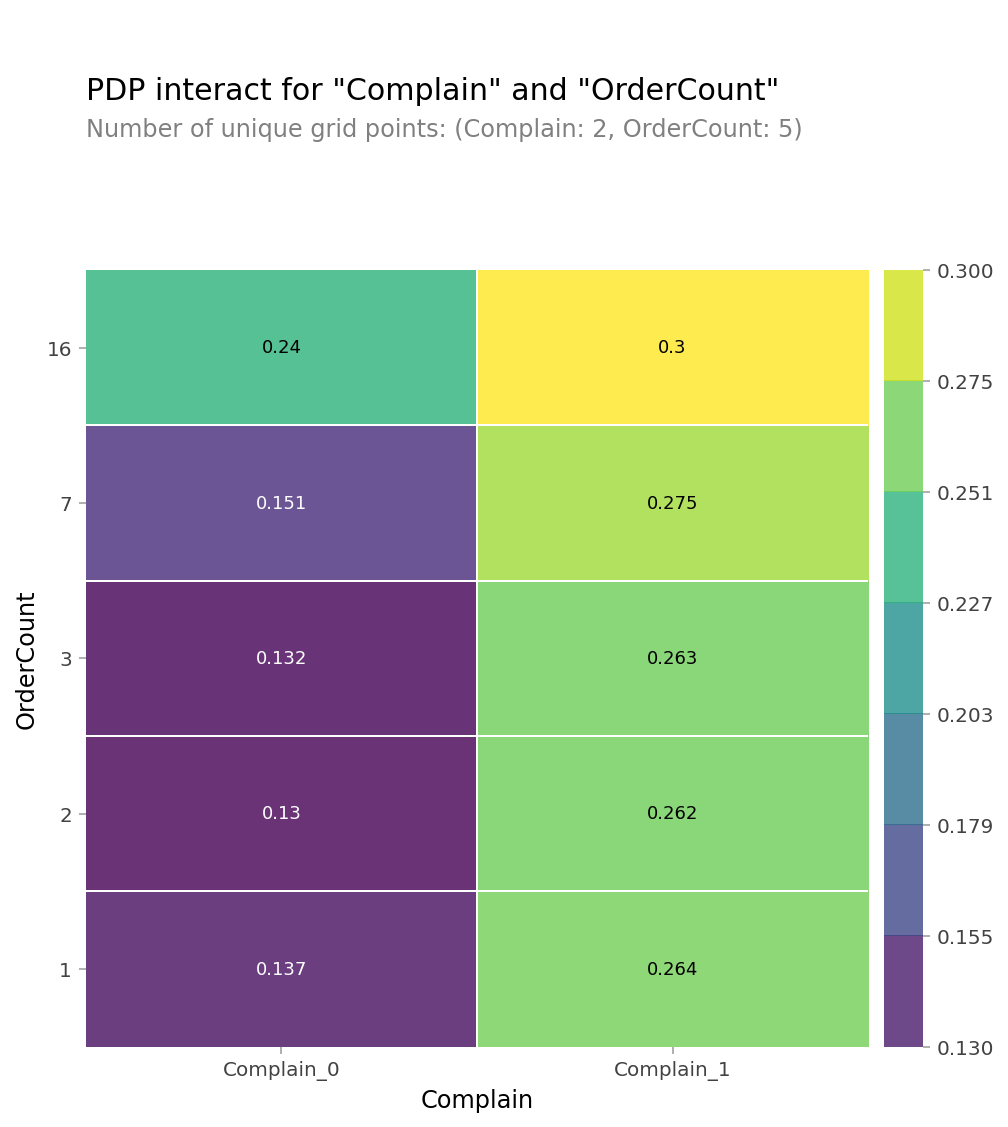

In [ ]:
features = ['Complain', 'OrderCount']

interaction = pdp_interact(
    model=pipe_ord, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

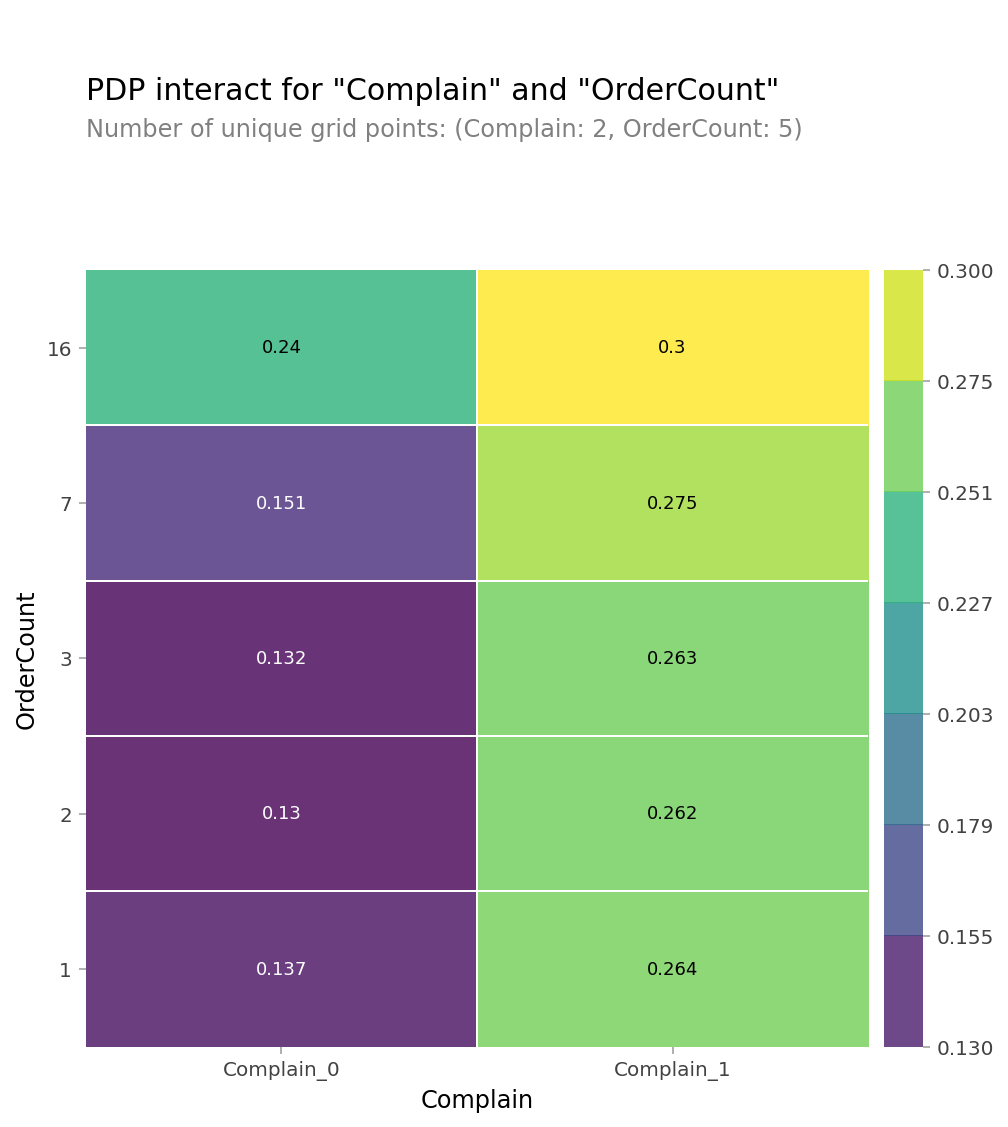

In [ ]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

In [ ]:
X_val_index = X_val.reset_index()['index']

In [ ]:
X_val

,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,avg_cashback
207,27.0,Computer,1,26.0,Debit Card,Female,2.0,3,Laptop & Accessory,3,Single,4,0,12.0,1.0,1.0,3.0,148.69,148.690000
5544,8.0,Mobile Phone,3,8.0,E wallet,Male,3.0,4,Fashion,1,Single,3,0,22.0,3.0,3.0,3.0,223.88,74.626667
3909,3.0,Mobile Phone,1,16.0,Credit Card,Female,3.0,4,Mobile Phone,3,Married,11,0,18.0,2.0,2.0,3.0,154.74,77.370000
2853,31.0,Mobile Phone,1,31.0,Debit Card,Male,3.0,3,Fashion,2,Married,5,1,17.0,2.0,2.0,3.0,219.39,109.695000
1179,13.0,Phone,1,18.0,Debit Card,Female,2.0,3,Laptop & Accessory,5,Married,3,0,12.0,7.0,7.0,7.0,144.48,20.640000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,23.0,Mobile Phone,1,25.0,Debit Card,Male,3.0,5,Others,3,Married,3,1,15.0,1.0,2.0,10.0,320.02,160.010000
964,10.0,Phone,1,19.0,Credit Card,Male,2.0,3,Laptop & Accessory,1,Married,2,0,17.0,0.0,3.0,7.0,142.85,47.616667
2339,25.0,Computer,1,34.0,Credit Card,Female,2.0,1,Grocery,3,Married,3,1,11.0,1.0,2.0,2.0,232.47,116.235000
5257,1.0,Phone,1,28.0,COD,Male,3.0,5,Mobile Phone,5,Married,2,0,15.0,1.0,2.0,1.0,147.96,73.980000


In [ ]:
X_val_encoded.reset_index()

,index,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,avg_cashback
0,207,27.0,1,1,26.0,1,1,2.0,3,2,3,3,4,0,12.0,1.0,1.0,3.0,148.69,148.690000
1,5544,8.0,2,3,8.0,2,2,3.0,4,3,1,3,3,0,22.0,3.0,3.0,3.0,223.88,74.626667
2,3909,3.0,2,1,16.0,3,1,3.0,4,1,3,1,11,0,18.0,2.0,2.0,3.0,154.74,77.370000
3,2853,31.0,2,1,31.0,1,2,3.0,3,3,2,1,5,1,17.0,2.0,2.0,3.0,219.39,109.695000
4,1179,13.0,3,1,18.0,1,1,2.0,3,2,5,1,3,0,12.0,7.0,7.0,7.0,144.48,20.640000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,3163,23.0,2,1,25.0,1,2,3.0,5,5,3,1,3,1,15.0,1.0,2.0,10.0,320.02,160.010000
1122,964,10.0,3,1,19.0,3,2,2.0,3,2,1,1,2,0,17.0,0.0,3.0,7.0,142.85,47.616667
1123,2339,25.0,1,1,34.0,3,1,2.0,1,4,3,1,3,1,11.0,1.0,2.0,2.0,232.47,116.235000
1124,5257,1.0,3,1,28.0,7,2,3.0,5,1,5,1,2,0,15.0,1.0,2.0,1.0,147.96,73.980000


In [ ]:
row = X_val_encoded.iloc[[200]]
row

,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,avg_cashback
4404,19.0,2,1,7.0,5,2,4.0,2,5,1,1,2,0,15.0,2.0,2.0,8.0,317.02,158.51


In [ ]:
import shap
row = X_val_encoded.iloc[[200]]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
)

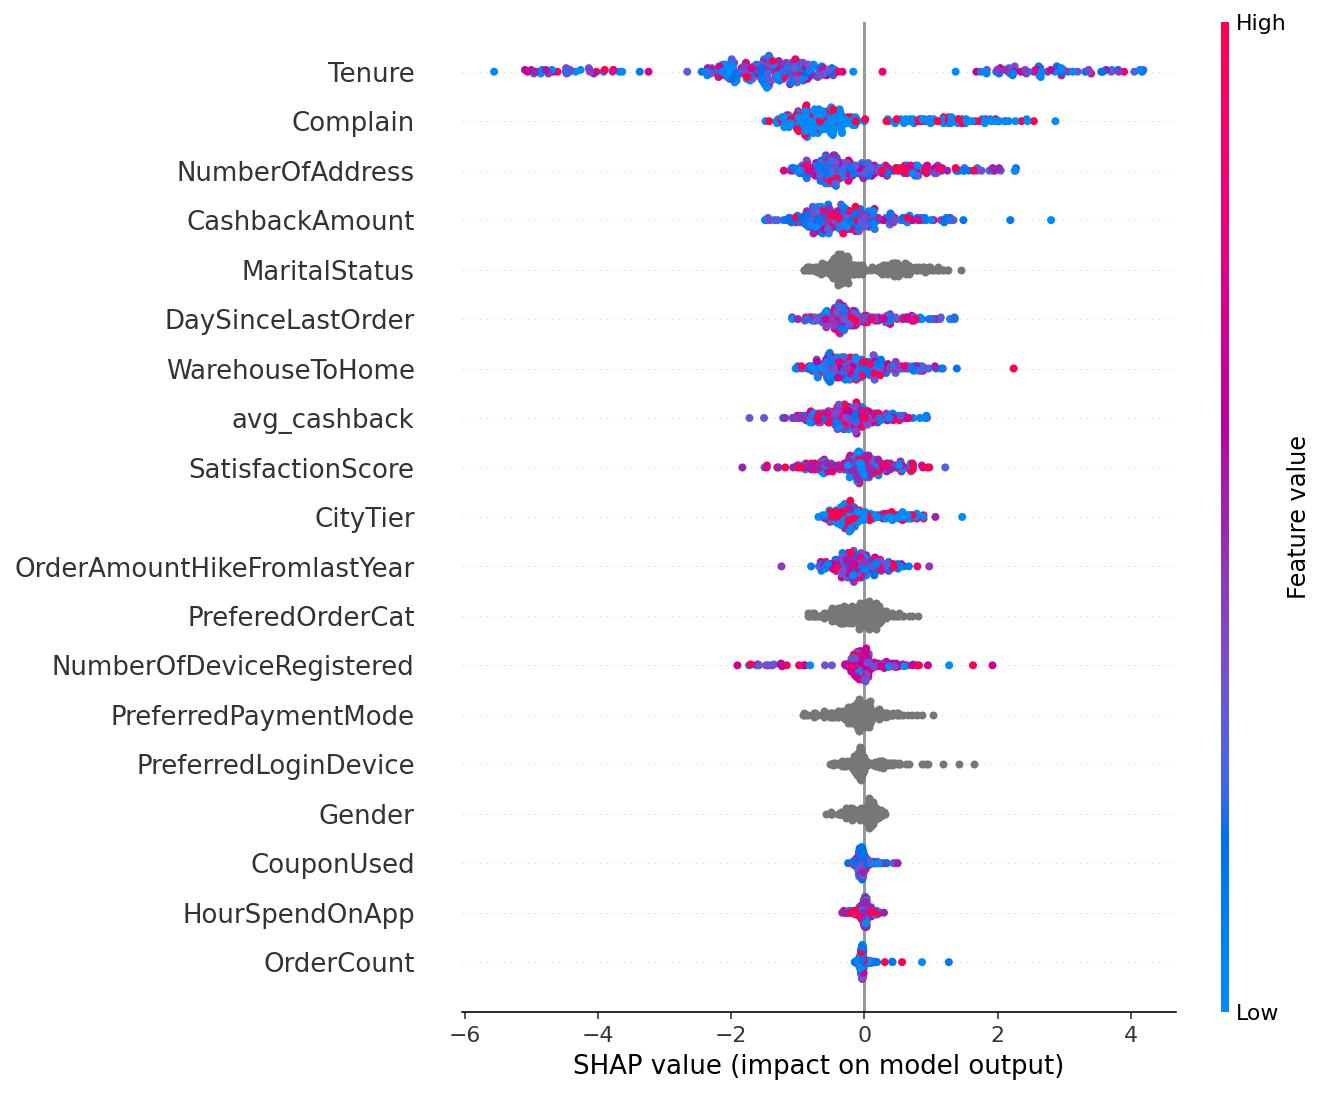

In [ ]:
shap_values = explainer.shap_values(X_val_encoded.iloc[:300])
shap.summary_plot(shap_values, X_train.iloc[:300])

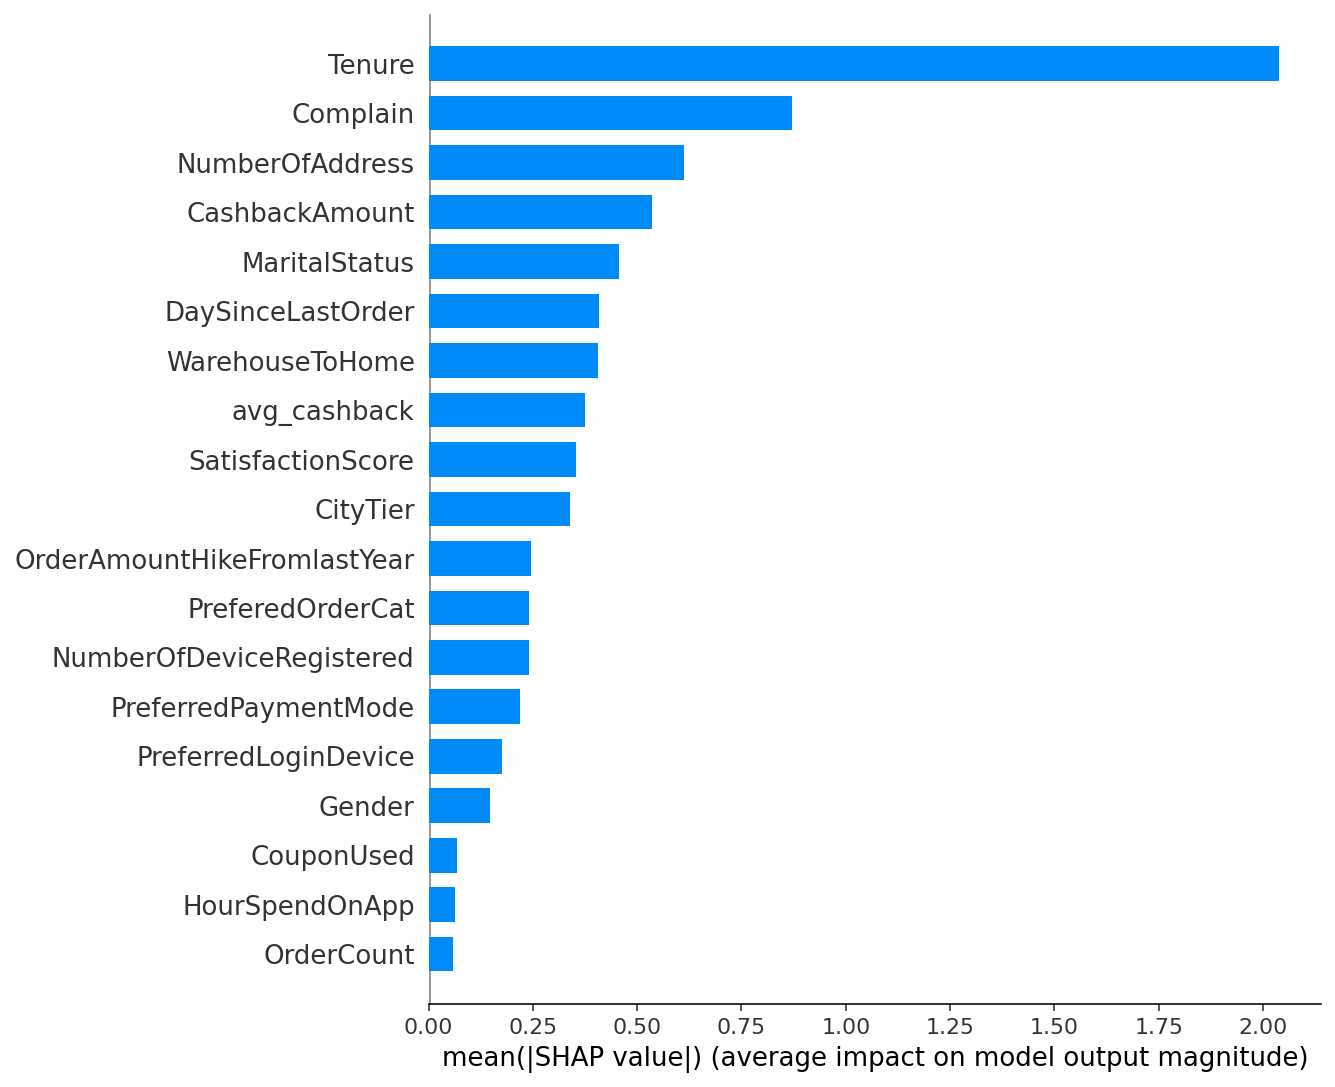

In [ ]:
shap.summary_plot(shap_values, X_train.iloc[:300], plot_type="bar")